In [1]:

# !pip install ipykernel

import os 

os.chdir('/home/DISCOVER_summer2022/xusc/exp/Cerberus-main')
# from dataloaders.datasets.nyud_geonet import NYUD_GeoNet

from dataloaders.datasets.iiw_dataset import IIWDataset
import matplotlib.pyplot as plt
import numpy as np 
import cv2
import scipy.io as scio
from eval_tools.iiw_evaluator import IIWEvaluator

from os.path import join, split, exists, isdir, isfile
from utils import * 

import torchvision.transforms as transforms 
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

from skimage import img_as_ubyte


Bad key text.latex.preview in file /home/DISCOVER_summer2022/xusc/.conda/envs/uav/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/DISCOVER_summer2022/xusc/.conda/envs/uav/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/DISCOVER_summer2022/xusc/.conda/envs/uav/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('s

In [46]:


import torch
    
    

def draw_point(img,point,point_color=(255,0,0),point_size = 1,thickness = 4):
    # thickness = 4 # 可以为 0 、4、8
    cv2.circle(img,point, point_size, point_color, thickness)

def gen_color():
    return (np.random.random((1,3))*255).astype(np.int32)[0].tolist() # BGR

def draw_point_pair(img,p1,p2):
    img = check_img(img)
    point_color = gen_color()
    draw_point(img,p1,point_color)
    draw_point(img,p2,point_color)
    draw_arraw(img,p1,p2,color=point_color,thickness=2,tipLength=0.09)


    return img
    


def draw_arraw(src,p1,p2,color=(0,0,255),thickness=2,line_type=0,shift=0,tipLength=0.1):
    """
    # int thickness #线宽
    # int line_type #线的类型
    # int shift #箭头位置平移系数
    # double tipLength  #箭头大小缩放系数
    """
    # Mask = 255*np.ones((100,100,3), dtype=np.int)
    # Mask = np.array(Mask, dtype='uint8')
    cv2.arrowedLine(src,p1, p2, color,thickness,line_type,shift,tipLength)


def draw_label(img,points,labels):
    if img.max()<=1:
        img = np.array(img*255,dtype=np.uint8)

    img = check_img(img)
    image_shape=torch.from_numpy(np.array(img.shape[:-1]))

    for idx,(points,label) in enumerate(zip(points,labels)):#* value range is between 0 and 1 

        # print(labels[idx])
        if label[0]!='E':
            p1= (points[0]*image_shape).int().numpy()
            p2= (points[1]*image_shape).int().numpy()
            img = draw_point_pair(img,p1,p2)
            
            
    return img




def draw_activated_points(image,edge_map,points,labels,shape=(512,512)):
    
    
    def inside_square(axis_x,axis_y,pred_edge_xy):
            #* filter the square
        min_border = np.where(pred_edge_xy[:,0] >= axis_x.min(),1,0)
        max_border = np.where(pred_edge_xy[:,0] <= axis_x.max(),1,0)
        pred_edge_xy = pred_edge_xy[min_border == max_border]

        min_border = np.where(pred_edge_xy[:,1] >= axis_y.min(),1,0)
        max_border = np.where(pred_edge_xy[:,1] <= axis_y.max(),1,0)
        pred_edge_xy = pred_edge_xy[min_border == max_border]
        return pred_edge_xy

    def in_same_line(p1,p2,xy,error_threshold = 1):
        
        vector1=p1-xy 
        vector2=p2-xy 
        # if vector1[0]/(vector1[1]+1e-5)  - vector2[0]/(vector2[1]+1e-5) < 1e-4:
        #     pass
        # print(abs(vector1[0]*vector2[1] -vector2[0]*vector1[1] ) / ((p1-p2)**2).sum()**(0.5))
        if abs(vector1[0]*vector2[1] -vector2[0]*vector1[1] ) / ((p1-p2)**2).sum()**(0.5)  < error_threshold: #* 1e+1, 4e+1 and 5e+1  the bound inside the line,  
        # if : #* 1e+1, 4e+1 and 5e+1  the bound inside the line,  
            return True

        return False
    
    #!=============================
    #? why 
    edge_map = np.concatenate([edge_map[:,1][:,None],edge_map[:,0][:,None]],axis=1)
    total_pair = recall_pair = 0
    
    #!=============================
    for idx,(point,label)  in enumerate(zip(points,labels)):
        if label[0] != 'E':
            total_pair+=1
            p1 = (point[0]*shape).int()
            p2 = (point[1]*shape).int()

            p12=torch.cat([p1[None,...],p2[None,...]],axis=0).numpy()
            axis_x = p12[:,0]
            axis_y = p12[:,1]

            pred_edge_xy= inside_square(axis_x,axis_y,edge_map.copy())
            
            #* debug
            image = draw_point_pair(image,p1.numpy(),p2.numpy())
            
            for idx in pred_edge_xy:
                xy = torch.from_numpy(idx).int()
                if  in_same_line(p1,p2,xy,1):
                    #* debug
                    # print('xy:',x,y,'\t p1:',p1,'\t p2:',p2)
                    # draw_point(image,xy.numpy(),point_color=gen_color(),point_size=1)
                    # draw_point(image,xy.numpy(),point_color=gen_color(),point_size=3)
                    # draw_point(image,xy.numpy(),point_color=gen_color(),point_size=5)
                    draw_point(image,xy.numpy(),point_color=(255,0,0),point_size=5)
                    recall_pair+=1
                    break
                    
        

    #* debug
    
    cv2.putText(image,f'{recall_pair} / {total_pair}', (20,30), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0), 2)
    
    # cv2.imwrite(self.gen_name()+'.jpg',self.tmp_img)
    return image



class Checker:


    def __init__(self,root,save_path,iiw_dataset = None,):

        self.dataset = iiw_dataset

        self.to_imger =transforms.ToPILImage()
        self.root  = root
        
        self.pre_path = join(root,'reflectance','met')
        self.predictions = sorted(os.listdir(self.pre_path))
        
        self.debug_save_path = save_path
        if not exists(self.debug_save_path):
            make_dir(self.debug_save_path)

    def __len__(self):
        
        return len(self.predictions)
    
    def name2idx(self,name):
        return self.predictions.index(name)


    
    def getitem(self,index):
        
        pred = load_mat(join(self.pre_path , self.predictions[index]))['result']
        name = self.get_name(index)

        image,points, labels = self.dataset.getitem_by_name(name)

        return np.array(self.to_imger(normalize(image))),points, labels,img_as_ubyte(pred),name
    
    def get_name(self,index):
        return self.predictions[index].split('.')[0]
    

    
    def get_qualitative_result(self,index,thresholds_range = np.arange(0.5,1,0.1)):

        name = self.get_name(index)
        name_format = '%s_%d.jpg'
        image_dict = {}
        for threshold in thresholds_range:
            save_path = join(self.debug_save_path,name_format%(name,round(threshold*100,2)))
            image_dict[threshold] = imread(save_path)[:,:,::-1]
        return image_dict
    
    def draw_qualitative_results(self,index,thresholds_range = np.arange(0.5,1,0.1)):

        image,points, labels,pred, name = self.getitem(index)

        name_format = '%s_%d.jpg'
        
        for threshold in thresholds_range:
            save_path = join(self.debug_save_path,name_format%(name,round(threshold*100,2)))
            
            if not exists(save_path):
                pred_xys = np.argwhere(pred/255 > threshold)#* trheshold == 0.5
                draw_activated_points_image =draw_activated_points(image,pred_xys,points,labels,np.array(pred.shape))

                # show_imgs([(pred/255 > threshold).astype(np.uint8)*255,draw_activated_points_image],
                #             [1,0],['Prediction','Groundtruth'],
                #             img_name = save_path)

                show_imgs([draw_activated_points_image],
                            [0],img_name = save_path)
                
        
    
    


run_iiw = "/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/networks/need2release/run_iiw"
dataset = IIWDataset(data_dir='/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/data/IIW/iiw-dataset',split='test')

rindnet_checker = Checker(join(run_iiw,'rindnet'),'logs/iiw_results_analysis/rindnet',dataset)
hed_checker = Checker(join(run_iiw,'hed'),'logs/iiw_results_analysis/hed',dataset)
our_checker = Checker('/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/networks/need2release/iiw_1',
                    'logs/iiw_results_analysis/ours',dataset)

    

In [35]:
# for idx in range(5):
#     rindnet_checker.draw_qualitative_results(idx)
#     hed_checker.draw_qualitative_results(idx)
    # ours_checker.draw_qualitative_results(idx)

# our_checker.draw_qualitative_results(0,[0.5])

##  comparsison betweein HED and RindNet

In [36]:
# demo_idx = 7
# tmp_save_path='logs/iiw_results_analysis/hed_rindnet'
# make_dir(tmp_save_path)

# for demo_idx in range(5):
#     hed_demo_img_dict = hed_checker.get_qualitative_result(demo_idx)
#     rindnet_demo_img_dict = rindnet_checker.get_qualitative_result(demo_idx)
#     our_demo_img_dict = our_checker.get_qualitative_result(demo_idx)

#     for threshold in np.arange(0.5,1,0.1):
#         print(threshold,'left: HED ,right: rindnet')
#         show_imgs([hed_demo_img_dict[threshold],rindnet_demo_img_dict[threshold]],[0,0,0],['HED','RindNet','Ours'],img_name=join(tmp_save_path,'%d_%d.jpg'%(threshold*100,demo_idx)))


## draw qualitative result 
### 1. get the recall or each datasets
### 2. pick up the best 

In [47]:



from utils import * 
import json 
class QulitativeSelector:
    
    

    def __init__(self,path,dataset_name = 'ours'):
        log_root = 'logs/iiw_results_analysis'
        
        self.root = path 
        self.log_path = join(log_root,dataset_name)
        
        self.json_path = join(path,'json')
        self.json_files  = sorted(os.listdir(self.json_path))
        self.checker = Checker(path,self.log_path,dataset)



    
    def __len__(self):
        return len(self.json_files )
    

    def get_quantitative_results_for_images(self):
        mean_metric_dict  = {}
        for idx,file_name in enumerate(self.json_files):
            with open(join(self.json_path,file_name),'r')as f :
                data = json.load(f)
            
            mean_metric_dict[file_name] = np.array(list(data.values())).mean()
        return mean_metric_dict
    
    def get_topx_idx(self,x):

        
        mean_metric_dict = self.get_quantitative_results_for_images()

        mean_metric_dict_after_sort = sorted(mean_metric_dict.items(), key =lambda k :k[1])
        
        # return [pair[0] for pair in mean_metric_dict_after_sort[::-1]][:x]
        return mean_metric_dict_after_sort[::-1][:x]


    

    def get_qualitatve_results(self,name,threshold_pickup = 0.5):
        idx = self.checker.name2idx(name)
        self.checker.draw_qualitative_results(idx,[threshold_pickup])
        image_list = self.checker.get_qualitative_result(idx,[threshold_pickup])
        return list(image_list.values())


    
def get_best_idx(main_dict,other_dict_list):

    
    n = len(other_dict_list)
    comparison_results = {}
    for main_k,main_value in main_dict.items():

        distance = 0 

        for d in other_dict_list:
            #* assume our is best 
            
            distance += (main_value - d[main_k])

        #* large is better
        comparison_results[main_k ] = distance/n
    


    return  sorted(comparison_results.items(), key =lambda k : k[1])[::-1]

        
ours_path = '/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/networks/need2release/iiw_1'
rindnet_root = '/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/networks/need2release/run_iiw'
        
ours = QulitativeSelector(ours_path,dataset_name='ours')
hed = QulitativeSelector(join(rindnet_root,'hed'),dataset_name = 'hed')
dff = QulitativeSelector(join(rindnet_root,'dff'),dataset_name = 'dff')
rcf = QulitativeSelector(join(rindnet_root,'rcf'),dataset_name = 'rcf')
rindnet = QulitativeSelector(join(rindnet_root,'rindnet'),dataset_name = 'rindnet')







In [38]:


# tops = 5
# tops_name = ours.get_topx_idx(tops)
# tops_name = [x.replace('json','mat') for x in tops_name]
# for name in tops_name[1:]:
#     comparison = ours.get_qualitatve_results(name) +hed.get_qualitatve_results(name) +dff.get_qualitatve_results(name) + rcf.get_qualitatve_results(name) +rindnet.get_qualitatve_results(name)
#     show_imgs(comparison,[0]*len(comparison),axis =1 )
#     break
    
    



In [48]:
best_qualitative_results = get_best_idx(main_dict=ours.get_quantitative_results_for_images(),
                                other_dict_list= [hed.get_quantitative_results_for_images(),
                                dff.get_quantitative_results_for_images(),rcf.get_quantitative_results_for_images(),
                                rindnet.get_quantitative_results_for_images()])

/home/DISCOVER_summer2022/xusc/.conda/envs/uav/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice.


In [40]:
# with open ('logs/iiw_results_analysis/show_ours_merits.json','w') as f :
#     json.dump({k:v for (k,v) in best_qualitative_results},f)

In [49]:
best_names  = [ x[0] for x in best_qualitative_results[:40]]


In [42]:
best_names[12]
#* picked : '103422.json'


'103422.json'

1232.mat
exist


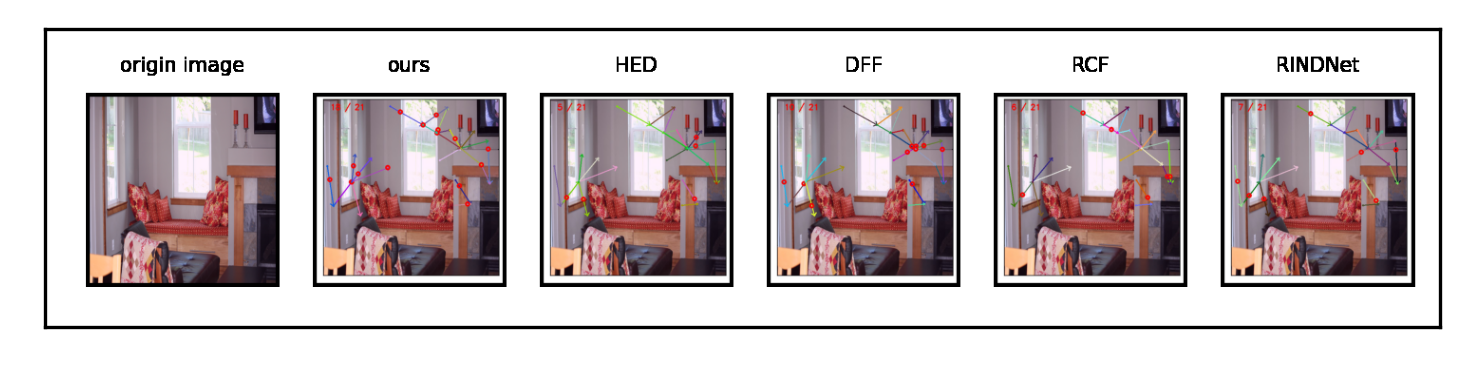

105931.mat
exist


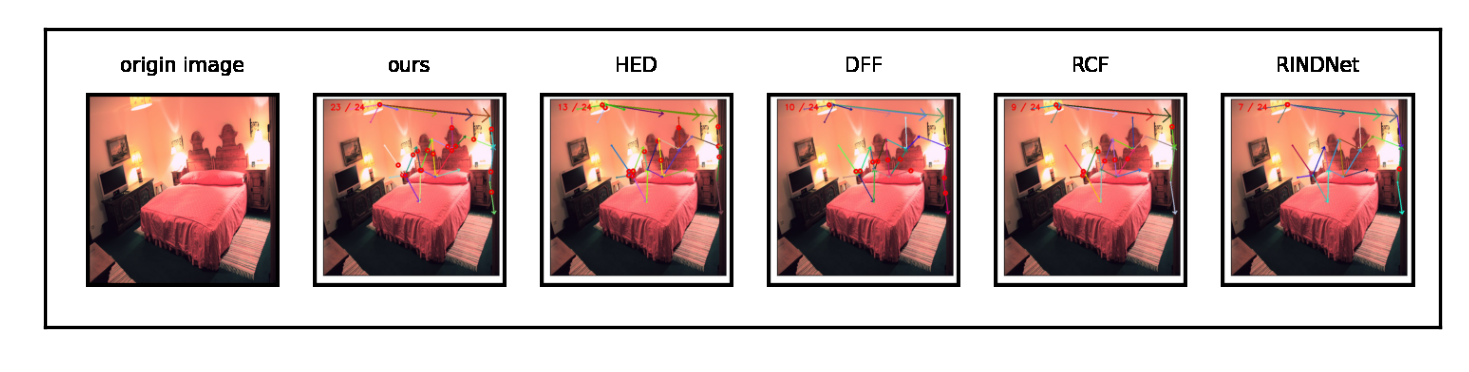

112869.mat
not exist
89105.mat
not exist
88741.mat
not exist
34465.mat
not exist
104478.mat
not exist
96131.mat
not exist
94480.mat
not exist
92952.mat
not exist
55736.mat
not exist
103422.mat
not exist
4032.mat
not exist
101693.mat
not exist
94190.mat
not exist
35796.mat
not exist
96511.mat
not exist
41375.mat
not exist
103924.mat
not exist
88841.mat
not exist
89491.mat
not exist
104648.mat
not exist
113764.mat
not exist
96864.mat
not exist
103335.mat
not exist
87162.mat
not exist
99200.mat
not exist
114414.mat
not exist
89060.mat
not exist
99880.mat
not exist
102570.mat
not exist
103536.mat
not exist
11139.mat
not exist
93322.mat
not exist
99564.mat
not exist
109805.mat
not exist
104537.mat
not exist
101984.mat
not exist
4496.mat
not exist


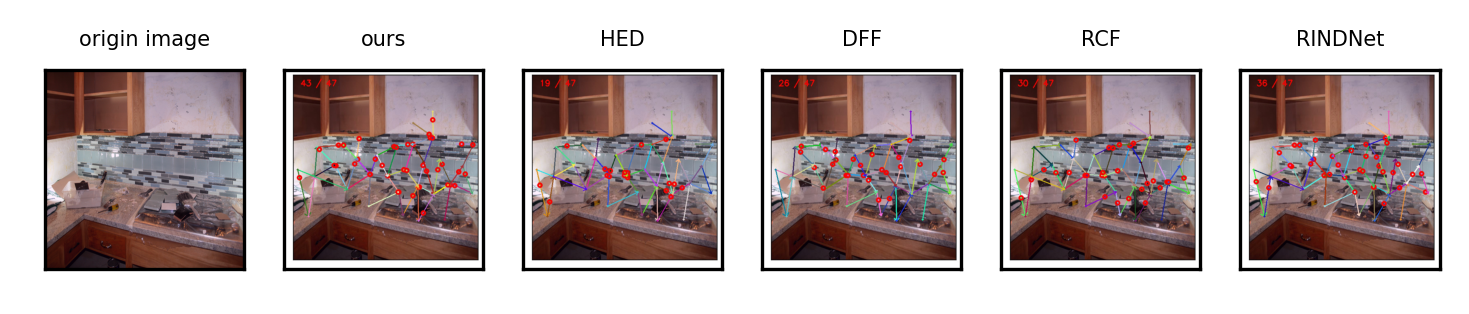

In [57]:


tmp_path = 'logs/iiw_results_analysis/tmp'
make_dir(tmp_path)
threshold_pickup = 0.6
for name in [x.replace('json','mat') for x in best_names][1:]:
    # image = image[:,:,::-1]
    print(name)
    
    save_name  = join(tmp_path,name.replace('mat','.png'))
    
    if not exists(save_name):
        print('not exist')
        image,pints,labels, pred, image_name= ours.checker.getitem(ours.checker.name2idx(name))
        
        comparison = [image] +ours.get_qualitatve_results(name,threshold_pickup) +hed.get_qualitatve_results(name,threshold_pickup) + \
                    dff.get_qualitatve_results(name,threshold_pickup) + rcf.get_qualitatve_results(name,threshold_pickup) +rindnet.get_qualitatve_results(name,threshold_pickup)

        show_imgs(comparison,[0]*len(comparison),titles= ['origin image','ours','HED','DFF','RCF','RINDNet'],axis =0,img_name=save_name)
    else:
        print('exist')
        show_imgs([imread(save_name)[:,:,::-1]],[0])
    
    
    